# Using BLS' CPI Microdata

Semi-automated tool to analyze inflation dynamics every time BLS releases new data

In [1]:
#import openpyxl
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

The following notebook works with the non-SA data output from the BLS' 'MultiScreen' query tool

https://www.bls.gov/data/home.htm

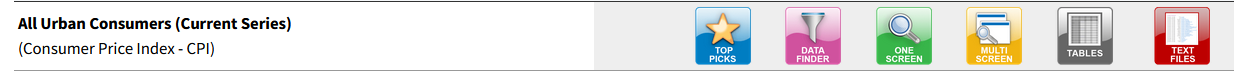

The query tool tends to freeze if we select everything so im making a tiny compromise and outputing just un-SA data from the following 14 geo areas

- 0000 U.S City Average
- 0100 Northeast
- 0110 New England
- 0120 Middle Atlantic
- 0200 Midwest
- 0230 East North Central
- 0240 West North Central
- 0300 South
- 0350 South Atlantic
- 0360 East South Central
- 0370 West South Central
- 0400 West
- 0480 Mountain
- 0490 Pacific

In [2]:
# Working directory setup

os.chdir('C:/Users/marco/Dropbox (MPD)/Analytics Argentina/Personal Files/MM/random_downloads/Python/Inflation')
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)

print("Files in current working directory:")
for file_name in files_in_directory:
    print(file_name)

Files in current working directory:
.ipynb_checkpoints
2022.xlsx
cpi-aggregate-items.xlsx
cpi-basic-item-aggregation.xlsx
cpi_bls23.xlsx
CPI_wrangler.ipynb
nov23.xlsx
raw.xlsx
weights_2022.xlsx
weight_description_mismatches.xlsx


In [3]:
# File uploaded is the BLS data series as the query outputs it, just renamed it to make it tidyier
# i dropped rows 1-3 before loading the dataframe, i have pending to integrate that step into the script

cpi=pd.read_excel('cpi_bls23.xlsx', sheet_name='BLS Data Series')

In [4]:
cpi.head()

,Series ID,Jan\n1980,Feb\n1980,Mar\n1980,Apr\n1980,May\n1980,Jun\n1980,Jul\n1980,Aug\n1980,Sep\n1980,...,Jun\n2023,Jul\n2023,Aug\n2023,Sep\n2023,Oct\n2023,Nov\n2023,Dec\n2023,Annual\n2023,HALF1\n2023,HALF2\n2023
0,CUUR0000SA0,77.8,78.9,80.1,81.0,81.8,82.7,82.7,83.3,84.0,...,305.109,305.691,307.026,307.789,307.671,307.051,NaN,NaN,302.408,NaN
1,CUUR0000SA0E,78.1,82.1,84.6,85.5,86.5,87.6,88.3,88.3,88.2,...,283.854,284.828,294.328,296.004,286.754,277.029,NaN,NaN,281.852,NaN
2,CUUR0000SA0L1,76.8,78.0,79.2,80.1,81.0,82.0,81.9,82.3,83.0,...,302.406,302.932,304.376,305.162,304.877,304.249,NaN,NaN,299.517,NaN
3,CUUR0000SA0L12,77.3,78.6,79.8,80.6,81.2,81.7,82.1,82.7,83.5,...,268.236,268.245,269.913,270.034,269.140,267.522,NaN,NaN,266.357,NaN
4,CUUR0000SA0L12E,77.0,77.8,78.6,79.3,79.8,80.2,80.6,81.2,82.4,...,269.235,269.102,269.642,269.536,269.858,269.409,NaN,NaN,267.351,NaN


### Basic wrangling and dataframe setup

In [5]:
# don't want the half year and annual mark columns

patterns = ['half', 'annual']
matching_columns = [col for col in cpi.columns
                        if any(re.search(pattern, col, re.IGNORECASE)for pattern in patterns)]

print(len(matching_columns), "columns found with pattern to be dropped")
cpi=cpi.drop(matching_columns, axis=1)

# plus editing the odd column formatting

new_colnames=[c.replace('\n', '-') for c in cpi.columns]
cpi.columns=new_colnames

132 columns found with pattern to be dropped


#### Understanding codification

Item codes have variable lenghts conditional on the aggregation level, so series_id lenght tells me the agg level implicitly

SA0 is the overal index, then goes SA1,2,3 for each aggregate which then unrolls into larger strings, making the whole code longer

Series name and area code are fixed, so overall stringh length depends entirely on the item code. i'll extract the item cosed based on this knowledge

In [6]:
print("min and max length for series ID: ")
print(cpi['Series ID'].str.len().min())
print(cpi['Series ID'].str.len().max())

min and max length for series ID: 
11
16


In [9]:
cpi['id_len']=cpi['Series ID'].str.len()

#4 digits for series name + 4 digits for area code; the rest is item code, so we know how to extract that substring

conditions = [ #note, these are already Series that say true/false for each row
    cpi['id_len'] == 11,
    cpi['id_len'] == 12,
    cpi['id_len'] == 13,
    cpi['id_len'] == 14,
    cpi['id_len'] == 15,
    cpi['id_len'] == 16
]

chars_to_substring=[3,4,5,6,7,8]

In [10]:
# extracting item and area code

cpi['item_code']='foo_item'
cpi['area_code']='foo_area'
cuur=len('CUUR') #inflation code, marks the start of the item code

for index, row in cpi.iterrows():
    for condition, substring in zip(conditions, chars_to_substring):
        if condition[index]==True:
            cpi.at[index, 'item_code']=cpi.at[index,'Series ID'][-substring:]
            cpi.at[index, 'area_code']=cpi.at[index,'Series ID'][cuur:-substring:]
            break # given that booleans are independent we can pass upon the first true

To fetch item descriptions i'm going to load the item aggregation workbook available at:

https://www.bls.gov/cpi/additional-resources/cpi-item-aggregation.htm

to make the file directly usable, i created a new sheet that has the table unformated and then a concat column that merges all aggregation levels into a same column. Very straightforward but i have pending to integrate to the script so as to eliminate manual tasks

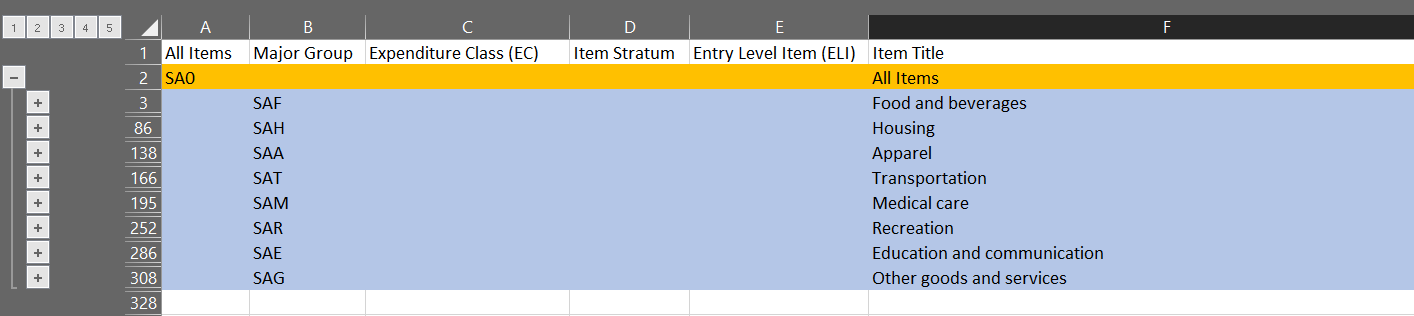

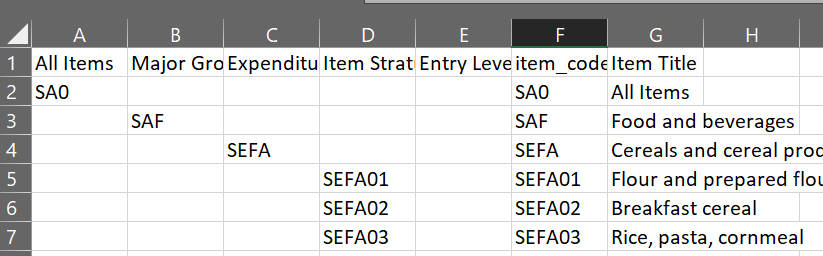

In [11]:
cpi_agg=pd.read_excel('cpi-basic-item-aggregation.xlsx', sheet_name='item_codes')

In [12]:
cpi_agg.head()

,All Items,Major Group,Expenditure Class (EC),Item Stratum,Entry Level Item (ELI),item_code,Item Title
0,SA0,NaN,NaN,NaN,NaN,SA0,All Items
1,NaN,SAF,NaN,NaN,NaN,SAF,Food and beverages
2,NaN,NaN,SEFA,NaN,NaN,SEFA,Cereals and cereal products
3,NaN,NaN,NaN,SEFA01,NaN,SEFA01,Flour and prepared flour mixes
4,NaN,NaN,NaN,SEFA02,NaN,SEFA02,Breakfast cereal


what it is easy to do in python is identifying the ident level based on what column has a value for that row in the agg table, if its column 0 ident level is 0 and so on

In [21]:
cpi_agg['indent_lvl']=0

for index,row in cpi_agg.iterrows():
    indent=0
    for column in cpi_agg.columns[:5]:
        if pd.isna(cpi_agg.at[index,column]):
            indent+=1
        else:
            cpi_agg.at[index,'indent_lvl']=indent
            break

# code_to_lvl=dict(zip(cpi_agg.item_code,cpi_agg.indent_lvl))
# cpi['indent_lvl']=cpi.item_code.map(code_to_lvl)

In [31]:
cpi_agg['indent_lvl'].value_counts()

3    211
2     70
4     36
1      8
0      1
Name: indent_lvl, dtype: int64

In [13]:
#looks like i've got a few more codes than listed in the codebook
print(cpi.item_code.unique().shape)
print(cpi_agg.item_code.unique().shape)

(398,)
(326,)


In [16]:
codes_in_df=cpi.item_code.unique()
codes_described=cpi_agg.item_code.unique()

items_not_described = list(set(codes_in_df) - set(codes_described))
print(len(items_not_described), "items with no description")
print(items_not_described)

150 items with no description
['SS04011', 'SA311', 'SS53023', 'SS20021', 'SAH3', 'SAF11', 'SS04031', 'SATCLTB', 'SAH2', 'SS17032', 'SAD', 'SAN1D', 'SS10011', 'SAF111', 'SA0R', 'SS62031', 'SAS24', 'SA0L5', 'SAGC', 'SANL1', 'SASLE', 'SS52051', 'SS16014', 'SAC', 'SS47016', 'SS02063', 'SERAC', 'SAF116', 'SS02042', 'SS61032', 'SS33032', 'SS53031', 'SAES', 'SA0L1E', 'SAA1', 'SS07011', 'SAA2', 'SS61021', 'SSFV031A', 'SAT1', 'SS4501A', 'SAF114', 'SARC', 'SSEE041', 'SAF1121', 'SS18043', 'SAF11211', 'SS62032', 'SAM2', 'SS53022', 'SA0L1', 'SS62051', 'SARS', 'SS06021', 'SAEC', 'SS05011', 'SS61031', 'SA0L12', 'SACL1E', 'SASL5', 'SS11031', 'SS27051', 'SS17031', 'SAG1', 'SS61011', 'SAM1', 'SS47015', 'SS53021', 'SS45031', 'SSHJ031', 'SACL11', 'SS05015', 'SS0206A', 'SACL1', 'SS48021', 'SS0206B', 'SAH1', 'SS0501A', 'SS20053', 'SS14022', 'SS31023', 'SS30021', 'SAN', 'SAS', 'SAS2RS', 'SAGS', 'SS45011', 'SS09021', 'SA0L12E4', 'SS47021', 'SAE21', 'SSEA011', 'SS5702', 'SS5703', 'SASL2RS', 'SS18064', 'SS07021

In [17]:
# looks like speciall aggregates or categories; altough im not going to use them initially, let us understand the available data
# i've got 3 instances of codes: ones that seem to be available per each area, then per large area and some only at the 0000 level

print(cpi[cpi['item_code'].isin(items_not_described)].item_code.value_counts().value_counts())
code_counts=cpi[cpi['item_code'].isin(items_not_described)].item_code.value_counts()

1     98
14    37
5     15
Name: item_code, dtype: int64


In [18]:
# checking the assumption
singles=code_counts[code_counts==1].index.tolist()
times5=code_counts[code_counts==5].index.tolist()
times14=code_counts[code_counts==14].index.tolist()

print(cpi[cpi['item_code'].isin(singles)].area_code.unique())
print(cpi[cpi['item_code'].isin(times5)].area_code.unique())
print(cpi[cpi['item_code'].isin(times14)].area_code.unique())

['0000']
['0000' '0100' '0200' '0300' '0400']
['0000' '0100' '0110' '0120' '0200' '0230' '0240' '0300' '0350' '0360'
 '0370' '0400' '0480' '0490']


seems to be the case, we can dig around and look for the descriptions for those special aggregations after finishing the basic setup

In [19]:
code_to_area={
    '0000': 'U.S City Average',
    '0100': 'Northeast',
    '0110': 'New England',
    '0120': 'Middle Atlantic',
    '0200': 'Midwest',
    '0230': 'East North Central',
    '0240': 'West North Central',
    '0300': 'South',
    '0350': 'South Atlantic',
    '0360': 'East South Central',
    '0370': 'West South Central',
    '0400': 'West',
    '0480': 'Mountain',
    '0490': 'Pacific',
}

code_to_item=dict(zip(cpi_agg['item_code'], cpi_agg['Item Title']))

cpi['area_descr']=cpi.area_code.map(code_to_area)
cpi['item_descr']=cpi.item_code.map(code_to_item) # we're going to have a bunch of Nulls here but shouldn't be a problem

#### Weighting

it is also relevant to know the relative importance of each subitem so we are also going to load the weight data from BLS

Tables 1 - 7, Relative Importance of Components in the Consumer Price Index, all areas (XLSX)

https://www.bls.gov/cpi/tables/relative-importance/home.htm

i'm also pending to incorporate the reshaping of the table to df format as part of the code

- dropped all initial rows that contain a description so im left with a table
- simplified colum names
- delete all empty rows (bls uses them to separate grand categories)
- deleted the rows that said "all items" but just as a header, with no weight
- added a column that flags the special aggregations at the bottom of the list, so as to avoid double counting in the future

In [36]:
weights=pd.read_excel("weights_2022.xlsx", sheet_name='edited')

# since the weights are provided by description and not code
# i'm going to simplify the text formatting so as to avoid mismatches

def clean_text(text):
    if type(text)==str:
        return text.strip().lower()
    else:
        return text
    
weights['item_descr']=weights['Item and Group'].apply(clean_text)
cpi['item_descr']=cpi['item_descr'].apply(clean_text)

Since there is a lot of extra stuff in the BLS series file, it makes more sense to look at it the other way around and plug in series data to the weight file

In [42]:
print(weights.shape)
weights.head()

(322, 6)


,Indent Level,Item and Group,CPI-U,CPI-W,Special aggregate,item_descr
0,0,All items,100.000,100.000,0,all items
1,1,Food and beverages,14.376,15.778,0,food and beverages
2,2,Food,13.531,15.073,0,food
3,3,Food at home,8.728,9.578,0,food at home
4,4,Cereals and bakery products,1.164,1.260,0,cereals and bakery products


In [48]:
print("lines per indent level:")
print(weights.loc[weights['Special aggregate']==0,'Indent Level'].value_counts(sort=False))
print("*"*20)
print("weight by indent level")
print(weights[weights['Special aggregate']==0].groupby('Indent Level')['CPI-U'].sum())

lines per indent level:
0      1
1      8
2     24
3     78
4    104
5     24
6     32
7     15
8      8
Name: Indent Level, dtype: int64
********************
weight by indent level
Indent Level
0    100.000
1     99.998
2     99.155
3    101.705
4     80.625
5     14.575
6      7.745
7      2.813
8      0.776
Name: CPI-U, dtype: float64


I sent an email to the BLS folks to try to understand why they dont make it add up to 100 for all indent levels but still havent got a response. Still indent 3 has 78 lines which seems like more than enough to decompose the index

In [ ]:
missing_descr= set(cpi.item_descr)-set(weights.item_descr)
print(len(missing_descr),"items missing")
for m in missing_descr:
    print(m)

there were some terminology updates incorporate in the weighting descriptions so there's some manual work needed to allign each description. the following dictionary resolves these incopatibilities:

In [ ]:
mismatch_fix=pd.read_excel('weight_description_mismatches.xlsx', sheet_name='edits')
fix_dict=dict(zip(mismatch_fix.original,mismatch_fix.weight_description))

cpi.loc[cpi.item_descr.isin(missing_descr),'item_descr']=cpi[cpi.item_descr.isin(missing_descr)].item_descr.map(fix_dict)
cpi['item_descr']=cpi['item_descr'].apply(clean_text)

In [ ]:
# re-check the mismatches

missing_descr2= set(cpi.item_descr)-set(weights.item_descr)
print(len(missing_descr2),"items missing")
for m in missing_descr2:
    print(m)

In [ ]:
# now the other way around

missing_weight= set(weights.item_descr)-set(cpi.item_descr)
print(len(missing_weight),"items missing")
for m in missing_weight:
    print(m)

In [ ]:
#plug in the weights
descr_to_weight=dict(zip(weights.item_descr,weights['CPI-U']))
cpi['weight2022']=cpi.item_descr.map(descr_to_weight)

In [ ]:
print(cpi[(cpi.indent_lvl==0)&(cpi.area_code=='0000')].weight2022.sum())
print(cpi[(cpi.indent_lvl==1)&(cpi.area_code=='0000')].weight2022.sum())
print(cpi[(cpi.indent_lvl==2)&(cpi.area_code=='0000')].weight2022.sum())
print(cpi[(cpi.indent_lvl==3)&(cpi.area_code=='0000')].weight2022.sum())

In [ ]:
cpi[(cpi.indent_lvl==3)].item_code.unique()